In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.optimize import curve_fit
from matplotlib.pyplot import figure

In [15]:
#import the spectrum
filepath = '/Users/mac/Desktop/cassi_folder/spectra_file/' + '695904062'
df = pd.read_csv('Data/target_LAMOST_RV.csv')
hdu_list = fits.open(filepath, memmap=True)
data = Table(hdu_list[2].data) #red spectrum
SNR = hdu_list[1].header['SNR']
if SNR < 10:
	raise ValueError("Signal To Noise must be bigger than 10")
obsid = hdu_list[0].header['OBSID']
star_name = hdu_list[0].header['DESIG']
LAMOST_vr = df.loc[df['designation']== star_name]["rv_br1"].values[0]

In [16]:
SNR

111.9

In [17]:
# Extract wavelength, flux, and uncertainties
wv = data["WAVELENGTH"][0]
fx = data["FLUX"][0]
errr = np.sqrt(1/data["IVAR"][0])

/var/folders/69/qyn6t8gs2d72s601sh3t50sc0000gn/T/ipykernel_39902/789282528.py:4: RuntimeWarning: divide by zero encountered in divide
  errr = np.sqrt(1/data["IVAR"][0])


## Step 1: Determine the radial velocity of the star

Minimum y value in range [6550, 6575]: 5228.6650390625
x values corresponding to minimum y: [6562.0527]


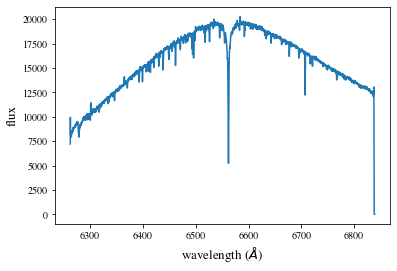

In [18]:
wv_0_Ha = 6562.8
c = 299792.458 #unit: km/s

#find the possible wavelength of the H-alpha to restrict the wavelength range
LAMOST_Ha = LAMOST_vr * wv_0_Ha / c + wv_0_Ha
Min = LAMOST_Ha - 5
Max = LAMOST_Ha + 5
within_range = (wv >= Min) & (wv <= Max)
wv_filtered = wv[within_range]
fx_filtered = fx[within_range]
min_fx = np.min(fx_filtered)
min_indices = np.where((fx_filtered == min_fx) & (fx_filtered != 0))[0]
wv_min = wv_filtered[min_indices]

plt.rcParams.update({'font.family':'times'})
plt.plot(wv, fx)
# plt.xlim(Min, Max)
plt.xlabel('wavelength ($\AA$)', size = 13)
plt.ylabel('flux', size = 13)
plt.savefig("/Users/mac/Desktop/cassi/plots.png", transparent=False, dpi=900, bbox_inches = 'tight')

print(f"Minimum y value in range [6550, 6575]: {min_fx}")
print(f"x values corresponding to minimum y: {wv_min}")

In [19]:
#calculate the radial velocity
def radial_velocity(wv_0, wv): 
	a = c * (wv - wv_0)/wv_0
	return a

v_r = radial_velocity(wv_0_Ha, wv_min)
v_r #km/s

array([-34.126602], dtype=float32)

## Step 2: Find the wavelength of lithium in the emission

In [20]:
wv_0_Li = 6707.856
wv_Li = wv_0_Li *(1 + v_r/c)
wv_Li

array([6707.0923], dtype=float32)

## Step 3: Find the line of best fit near lithium line

Slope (m): -35.33449132533093 ± -35.33449132533093
Intercept (c): 22165.82952909439 ± 22165.82952909439


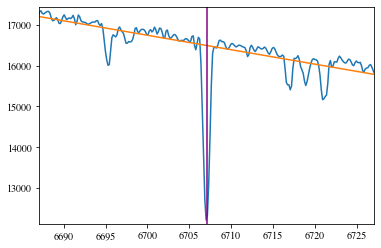

In [21]:
@custom_model
def sum_of_gaussians(x, amplitude=1., mean=-1., sigma=1.):
	try:
		return (amplitude * np.exp(-0.5 * ((x - mean) / sigma)**2) + 1)
	except Exception as e:
		print(f"Gaussian fit failed: {e}")
		return 1e6  # Large default value if fit fails

#filter out the region for linear best fit line
wv_Li_min = wv_Li - 20
wv_Li_max = wv_Li + 20
wv_range = (wv >= wv_Li_min) & (wv <= wv_Li_max)
wv_filtered = wv[wv_range]
fx_filtered = fx[wv_range]
errr_filtered = errr[wv_range]

#fit with account to the uncertainty
def linear_model(x, m, c):
	return m * x + c
popt, pcov = curve_fit(linear_model, wv_filtered, fx_filtered, sigma=errr_filtered, absolute_sigma=True)
m, c = popt
line_of_best_fit = m * wv_filtered + c

#omit the outlier
residuals = fx_filtered - line_of_best_fit
residuals_std = np.std(residuals)
threshold = 3 * residuals_std

# Filter out points with large residuals
mask = np.abs(residuals) < threshold
wv_removed = wv_filtered[mask]
fx_removed = fx_filtered[mask]
errr_filtered = errr_filtered[mask]

popt, pcov = curve_fit(linear_model, wv_removed - np.mean(wv), fx_removed, sigma=errr_filtered, absolute_sigma=True)
m, c = popt
print(f"Slope (m): {m} ± {popt[0]}")
print(f"Intercept (c): {c} ± {popt[1]}")
line_of_best_fit = m * (wv - np.mean(wv)) + c

plt.plot(wv, fx)
plt.plot(wv, line_of_best_fit)
plt.xlim(wv_Li_min, wv_Li_max)
plt.ylim(np.min(fx_filtered) - 100, np.max(fx_filtered) + 100)
plt.vlines(x=wv_Li, ymax = np.max(fx_filtered) + 100, ymin = np.min(fx_filtered) - 100, color = "purple")
plt.show()

## Step 4: Reduce the spectra with respect to the line of best fit

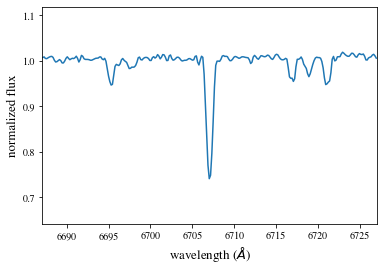

In [22]:
fx_normalized_filtered = (fx/line_of_best_fit)[wv_range]
errr_normalized_filtered = (errr/line_of_best_fit)[wv_range]

plt.rcParams.update({'font.family':'times'})
plt.plot(wv_filtered, fx_normalized_filtered)
plt.xlim(wv_Li_min, wv_Li_max)
plt.ylim(np.min(fx_normalized_filtered) - 0.1, np.max(fx_normalized_filtered)+0.1)
plt.xlabel('wavelength ($\AA$)', size = 13)
plt.ylabel('normalized flux', size = 13)
plt.savefig("/Users/mac/Desktop/cassi/plots.png", transparent=False, dpi=900, bbox_inches = 'tight')
plt.show()

## Step 5: Fit the Gaussian model to this region

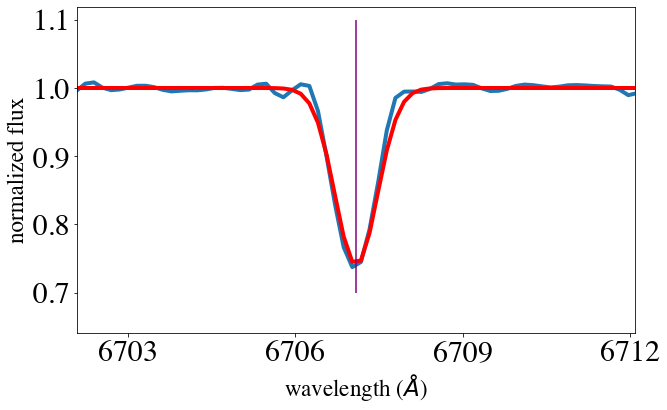

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
Amplitude: -0.2591926143751523
Reduced chi²: 5.6267224319408236
EW: -0.4373272000878208 ± -0.004748481778314567


In [26]:
sigma_Li = wv_Li/7500/2.3548
m_init = sum_of_gaussians(amplitude=-0.05,mean=wv_Li,sigma=sigma_Li)

#constraints
m_init.amplitude.fixed = False
m_init.mean.fixed = True
m_init.sigma.fixed = True
m_init.amplitude.min = -1
m_init.amplitude.max = 0

# 4. Fit and catch fitting errors
fit = LevMarLSQFitter()
fx_final = fx_normalized_filtered / np.median(fx_normalized_filtered)
errr_final = errr_normalized_filtered / np.median(fx_normalized_filtered)

try:
	m = fit(m_init, wv_filtered, fx_final, maxiter=500, weights=1/errr_final)
	cov = fit.fit_info['param_cov']
	error = cov**0.5

	# Equivalent width
	W = m.amplitude.value * m.sigma.value * np.sqrt(2) * np.pi
	W_error = -error[0][0] / m.amplitude.value * W if m.amplitude.value != 0 else np.nan

	# chi²
	y_pred = m(wv_filtered)
	chi2 = np.sum(((fx_final - y_pred) / errr_final)**2)
	reduced_chi2 = chi2 / (len(wv_filtered) - 1)

	# Plot
	fig = figure(figsize=(10, 6))
	plt.plot(wv_filtered, fx_final, lw=4)
	plt.plot(wv, m(wv), color='r', lw=4)
	plt.xticks(np.arange(6697, 6713, step=3), fontsize=30)
	plt.yticks(np.arange(0, 1.20, step=0.1), fontsize=30)
	plt.xlim(wv_Li_min + 15, wv_Li_max - 15)
	plt.ylim(np.min(fx_normalized_filtered) - 0.1, np.max(fx_normalized_filtered) + 0.1)
	plt.xlabel('wavelength ($\AA$)', size=23)
	plt.ylabel('normalized flux', size=23)
	plt.vlines(x=wv_Li, ymax=1.10, ymin=0.7, color="purple")
	plt.show()

	print(fit.fit_info['message'])
	print(f"Amplitude: {m.amplitude.value}")
	print(f"Reduced chi²: {reduced_chi2}")
	print(f"EW: {W} ± {W_error}")

except Exception as e:
	print(f"Fit failed: {e}")
	reduced_chi2 = 1e6
	W = 1e6
	W_error = 1e6
	print("Gaussian fit failed. Returning large dummy values.")